# Import Libraries and Settings

In [ ]:
import os
import sys
import re
import string
import nltk
import numpy as np
import pandas as pd
import tensorflow as tf
from shutil import unpack_archive


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
# from nltk.probability import FreqDist
# from spacy.lang.en import English
# from spacy.lang.en.stop_words import STOP_WORDS

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

lemma = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!{sys.executable} -m pip install wget
!{sys.executable} -m pip install shutil

!wget 'https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip'

print('Extracting Glove6B')
unpack_archive('glove.6B.zip')

print('Remove Extra Files')
os.remove('glove.6B.100d.txt')
os.remove('glove.6B.200d.txt')
os.remove('glove.6B.50d.txt')
os.remove('glove.6B.zip')

print('Process finished')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=c0a74c4f426482f3066f7ce6ce28677b2fe9461e3613ae1ce6e1ecdf94f13388
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil
--2022-07-27 13:46:25--  https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip
Resolving huggingface.co (huggingface.co)... 52.2.34.29, 34.231.117.252, 2600:1f18:147f:e850:d57d:d46a:df34:61ee, ...
Connecting to huggingface.co (huggingface.co)|52.2.34.29|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/stanfordnl

In [ ]:
path_to_glove_file = "/content/glove.6B.300d.txt"
path_to_tweets_file = "/content/drive/MyDrive/DTS/Data/tweets.csv"

# Import Data

In [ ]:
tweets = pd.read_csv(path_to_tweets_file)
tweets = tweets[["text", "target"]]
tweets.head(5)

,text,target
0,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,Telangana: Section 144 has been imposed in Bha...,1
2,Arsonist sets cars ablaze at dealership https:...,1
3,Arsonist sets cars ablaze at dealership https:...,1
4,"""Lord Jesus, your love brings freedom and pard...",0


# EDA

In [ ]:
# from wordcloud import WordCloud
# plt.figure(figsize=(12,6))
# text = ' '.join(train.no_stopwords[train['target']==1])
# wc = WordCloud(background_color='white',stopwords=stopwords).generate(text)
# plt.imshow(wc)

In [ ]:
# from wordcloud import WordCloud
# plt.figure(figsize=(12,6))
# text = ' '.join(train.no_stopwords[train['target']==0])
# wc = WordCloud(background_color='white',stopwords=stopwords).generate(text)
# plt.imshow(wc)

# Preprocess Data

### Clean

In [ ]:
# Create custom functions
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

def remove_stopwords(text):
    text = word_tokenize(text)
    text = [word for word in text if word not in set(nltk.corpus.stopwords.words('english'))]
    return [' '.join(map(str, l)) for l in text]

In [ ]:
# clean text
tweets['clean_text'] = tweets['text'].apply(lambda x: remove_URL(x))
tweets['clean_text'] = tweets['clean_text'].apply(lambda x: remove_emoji(x))
tweets['clean_text'] = tweets['clean_text'].apply(lambda x: remove_html(x))
tweets['clean_text'] = tweets['clean_text'].apply(lambda x: remove_punct(x))

# lower text
tweets['lowered'] = tweets['clean_text'].apply(lambda x: x.lower())

# remove stopwords
tweets['no_stopwords'] = tweets['lowered'].apply(word_tokenize)
tweets['no_stopwords'] = tweets['no_stopwords'].apply(
    lambda x: [word for word in x 
               if word not in set(nltk.corpus.stopwords.words('english'))])
tweets['no_stopwords'] = [' '.join(map(str, l)) for l in tweets['no_stopwords']]

# lemmatize
tweets['lemmatized'] = tweets['no_stopwords'].apply(lambda x: lemma.lemmatize(x))

# Check data
tweets.head(5)

,text,target,clean_text,lowered,no_stopwords,lemmatized
0,"Communal violence in Bhainsa, Telangana. ""Ston...",1,Communal violence in Bhainsa Telangana Stones ...,communal violence in bhainsa telangana stones ...,communal violence bhainsa telangana stones pel...,communal violence bhainsa telangana stones pel...
1,Telangana: Section 144 has been imposed in Bha...,1,Telangana Section 144 has been imposed in Bhai...,telangana section 144 has been imposed in bhai...,telangana section 144 imposed bhainsa january ...,telangana section 144 imposed bhainsa january ...
2,Arsonist sets cars ablaze at dealership https:...,1,Arsonist sets cars ablaze at dealership,arsonist sets cars ablaze at dealership,arsonist sets cars ablaze dealership,arsonist sets cars ablaze dealership
3,Arsonist sets cars ablaze at dealership https:...,1,Arsonist sets cars ablaze at dealership,arsonist sets cars ablaze at dealership,arsonist sets cars ablaze dealership,arsonist sets cars ablaze dealership
4,"""Lord Jesus, your love brings freedom and pard...",0,Lord Jesus your love brings freedom and pardon...,lord jesus your love brings freedom and pardon...,lord jesus love brings freedom pardon fill hol...,lord jesus love brings freedom pardon fill hol...


In [ ]:
tweets.iloc[0, :]

text            Communal violence in Bhainsa, Telangana. "Ston...
target                                                          1
clean_text      Communal violence in Bhainsa Telangana Stones ...
lowered         communal violence in bhainsa telangana stones ...
no_stopwords    communal violence bhainsa telangana stones pel...
lemmatized      communal violence bhainsa telangana stones pel...
Name: 0, dtype: object

# Split data

In [ ]:
data = pd.DataFrame()

data["text"] = tweets["no_stopwords"]
data["target"] = tweets["target"]
data.head(5)

,text,target
0,communal violence bhainsa telangana stones pel...,1
1,telangana section 144 imposed bhainsa january ...,1
2,arsonist sets cars ablaze dealership,1
3,arsonist sets cars ablaze dealership,1
4,lord jesus love brings freedom pardon fill hol...,0


In [ ]:
# Split data into train, test, and validation
X_train, X_test, y_train, y_test  = train_test_split(
    data.text, 
    data.target, 
    stratify = data.target, 
    test_size = 0.2, 
    random_state = 321
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train, 
    stratify = y_train, 
    test_size = 0.2, 
    random_state = 321)

# Check Data
print(f"Train Dataset Size = {len(X_train)}")
print(f"Val Dataset Size = {len(X_val)}")
print(f"Test Dataset Size = {len(X_test)}")

Train Dataset Size = 7276
Val Dataset Size = 1820
Test Dataset Size = 2274


In [ ]:
# Tokenize words
tokenizer = Tokenizer(oov_token = "<<OOV>>")
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

# Create sequences
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

X_train = pad_sequences(sequences_train, maxlen=256, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=256, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=256, truncating='pre')

# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_val = le.fit_transform(y_val)

# Check data
vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 22025


# Word Embedding

In [ ]:
embeddings_index = {}
embedding_dim = 300
hits = 0
misses = 0
num_tokens = vocabSize

# Read word vectors
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))


# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400001 word vectors.
Converted 15564 words (6460 misses)


# Deep Learning Models

In [ ]:
optimizerSGD  = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
optimizerADAM = tf.keras.optimizers.Adam(learning_rate=1e-4)

In [ ]:
# Model 1
model_1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        num_tokens, embedding_dim,
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=False),
    tf.keras.layers.Conv1D(filters=216, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=216, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences = True)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_1.compile(loss = 'binary_crossentropy', 
              optimizer = optimizerADAM, 
              metrics = ['accuracy'])
model_1.summary()

history_1 = model_1.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         6607500   
                                                                 
 conv1d (Conv1D)             (None, None, 216)         194616    
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 216)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 216)         140184    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 216)        0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, None, 216)         0

In [ ]:
# Model 2
model_2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        num_tokens, embedding_dim,
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=False),
    tf.keras.layers.Conv1D(filters=216, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=216, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences = True)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_2.compile(loss = 'binary_crossentropy', 
              optimizer = optimizerSGD, 
              metrics = ['accuracy'])
model_2.summary()

history_2 = model_2.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         6607500   
                                                                 
 conv1d_2 (Conv1D)           (None, None, 216)         194616    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 216)        0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, None, 216)         140184    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, None, 216)        0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, None, 216)        

KeyboardInterrupt: ignored

In [ ]:
# Model 3
model_3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        num_tokens, embedding_dim,
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=False),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu"),
    tf.keras.layers.Conv1D(filters=128, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu"),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences = True)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_3.compile(loss = 'binary_crossentropy', 
              optimizer = optimizerADAM, 
              metrics = ['accuracy'])
model_3.summary()

history_3 = model_3.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), verbose=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 300)         6607500   
                                                                 
 conv1d_4 (Conv1D)           (None, None, 128)         115328    
                                                                 
 conv1d_5 (Conv1D)           (None, None, 128)         82048     
                                                                 
 conv1d_6 (Conv1D)           (None, None, 128)         49280     
                                                                 
 dropout_8 (Dropout)         (None, None, 128)         0         
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 2048)       9445376   
 nal)                                                            
                                                      

In [ ]:
# Model 4
model_4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        num_tokens, embedding_dim,
        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
        trainable=False),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu"),
    tf.keras.layers.Conv1D(filters=128, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu"),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences = True)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_4.compile(loss = 'binary_crossentropy', 
              optimizer = optimizerSGD, 
              metrics = ['accuracy'])
model_4.summary()

history_4 = model_4.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), verbose=1)

In [ ]:
model_1.evaluate(X_test, y_test, verbose=1)
model_2.evaluate(X_test, y_test, verbose=1)
model_3.evaluate(X_test, y_test, verbose=1)
model_4.evaluate(X_test, y_test, verbose=1)

In [ ]:
# Rangkuman history dari proses fit accuracy setiap Model dengan dataset val per-epoch
plt.plot(history_1.history['val_accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Evaluasi Accuracy per-epoch')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend(['Model 1', 'Model 2', 'Model 3', 'Model 4'], loc='upper right')
plt.show()

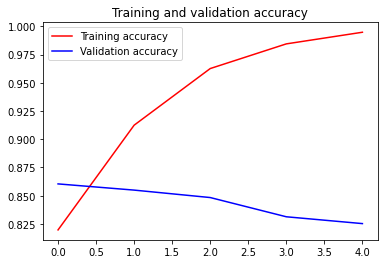

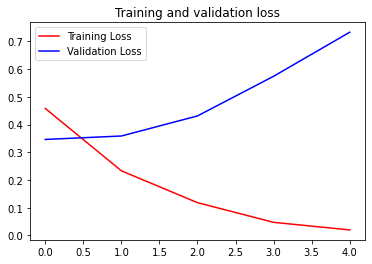

In [ ]:
# # Visualize Loss & Accuracy
# %matplotlib inline
# import matplotlib.pyplot as plt
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(len(acc))

# plt.plot(epochs, acc, 'r', label='Training accuracy')
# plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.legend()
# plt.figure()

# plt.plot(epochs, loss, 'r', label='Training Loss')
# plt.plot(epochs, val_loss, 'b', label='Validation Loss')
# plt.title('Training and validation loss')
# plt.legend()

# plt.show()

In [ ]:
# Classify custom sample

sentences = [
            #sample teks
             "Married woman sets husband ablaze for allegedly cheating on her in Osogbo,Osun state Nigeria", #https://twitter.com/Celebrity_blogg/status/1549794206360764416
             "Ken Green won five times on the PGA Tour. In 2009, he lost his right leg in an RV accident.", #https://twitter.com/GolfweekNichols/status/1549046955720216576
             "I'd like to report the entire audience who attended my #Armageddon warm up tonight for hate crimes. They laughed, and sometimes even clapped, at terrible things, in the name of 'comedy'. Disgusting.", #https://twitter.com/rickygervais/status/1546599859603603462
             "Sometimes we have to get lost to find ourselves in a better place and get out of the wrecked place we unknowingly got trapped in", #https://twitter.com/dozyneedcoffee/status/1550488706296995840
             "This man on tiktok rap battle every living being in his house" #https://twitter.com/tinaqueen_15/status/1550267812479901701
            ]

df_test = pd.DataFrame (sentences, columns = ['sentences'])
df_test = pd.read_csv("/content/train.csv")

# clean text
df_test['clean_text'] = df_test['text'].apply(lambda x: remove_URL(x))
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: remove_emoji(x))
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: remove_html(x))
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: remove_punct(x))

# lower text
df_test['lowered'] = df_test['clean_text'].apply(lambda x: x.lower())

# remove stopwords
df_test['no_stopwords'] = df_test['lowered'].apply(word_tokenize)
df_test['no_stopwords'] = df_test['no_stopwords'].apply(
    lambda x: [word for word in x 
               if word not in set(nltk.corpus.stopwords.words('english'))])
df_test['no_stopwords'] = [' '.join(map(str, l)) for l in df_test['no_stopwords']]

# lemmatize
df_test['lemmatized'] = df_test['no_stopwords'].apply(lambda x: lemma.lemmatize(x))

In [ ]:
Z = df_test['lemmatized']

sequences_test2 = tokenizer.texts_to_sequences(Z)
X_test2 = pad_sequences(sequences_test2, maxlen=256, truncating='pre')

In [ ]:
df_test['target'] = le.fit_transform(df_test['target'])
model.evaluate(X_test2, df_test['target'], verbose = 1)

238/238 [==============================] - 34s 136ms/step - loss: 2.0803 - accuracy: 0.6631


[2.0803005695343018, 0.6630763411521912]

0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64

## Visualisation of the results

In [ ]:
# def plot_training_hist(history):
#     '''Function to plot history for accuracy and loss'''
    
#     fig, ax = plt.subplots(1,2, figsize=(10,4))
#     # first plot
#     ax[0].plot(history.history['accuracy'])
#     ax[0].plot(history.history['val_accuracy'])
#     ax[0].set_title('Model Accuracy')
#     ax[0].set_xlabel('epoch')
#     ax[0].set_ylabel('accuracy')
#     ax[0].legend(['train', 'validation'], loc='best')
    
#     # second plot
#     ax[1].plot(history.history['loss'])
#     ax[1].plot(history.history['val_loss'])
#     ax[1].set_title('Model Loss')
#     ax[1].set_xlabel('epoch')
#     ax[1].set_ylabel('loss')
#     ax[1].legend(['train', 'validation'], loc='best')
    
# plot_training_hist(history)

In [ ]:
# from sklearn.metrics import confusion_matrix

# def plot_confusion_matrix(model, X_test, y_test):
#     '''Function to plot confusion matrix for the passed model and the data'''
    
#     sentiment_classes =   ['Negative','Neutral', 'Positive']
#     # use model to do the prediction
#     y_pred = model.predict(X_test)
#     # compute confusion matrix
#     cm = confusion_matrix(np.argmax(y_pred, axis=1),np.argmax(np.array(y_test),axis=1))

#     print(pd.Series(np.argmax(np.array(y_test),axis=1)).value_counts())
#     print(pd.Series(np.argmax(y_pred, axis=1)).value_counts())
    
#     # plot confusion matrix
#     plt.figure(figsize=(8,6))
#     sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
#                 xticklabels=sentiment_classes,
#                 yticklabels=sentiment_classes)
#     plt.title('Confusion matrix', fontsize=16)
#     plt.xlabel('Actual label', fontsize=12)
#     plt.ylabel('Predicted label', fontsize=12)
    
# plot_confusion_matrix(model, X_test, y_test)

# Traditional Machine Learning Model

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_validate, KFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [ ]:
clf = LogisticRegression(C=1,random_state=42)
clf.fit(X_train, y_train)
prediction = clf.predict(X_val)
print(confusion_matrix(y_val, prediction))
print(accuracy_score(y_val, prediction))
print(classification_report(y_val, prediction))
print(f1_score(y_val, prediction))

In [ ]:
svm=SVC()
svm.fit(X_train,y_train)
prediction = svm.predict(X_val)
print(confusion_matrix(y_val, prediction))
print(accuracy_score(y_val, prediction))
print(classification_report(y_val, prediction))
print(f1_score(y_val, prediction))

In [ ]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)
prediction = rfc.predict(X_val)
print(confusion_matrix(y_val, prediction))
print(accuracy_score(y_val, prediction))
print(classification_report(y_val, prediction))
print(f1_score(y_val, prediction))

In [ ]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
prediction = nb.predict(X_val)
print(confusion_matrix(y_val, prediction))
print(accuracy_score(y_val, prediction))
print(classification_report(y_val, prediction))
print(f1_score(y_val, prediction))